 # Groundwater Level Forecasting – 3-Layer LSTM (Full Notebook)



 This notebook performs:

 - Time selection

 - Feature engineering

 - Sliding-window dataset creation

 - Train/Val/Test split

 - Grid Search for LSTM

 - Final retraining

 - Evaluation

 - Permutation Feature Importance

 - SHAP interpretability

 ## 0. Imports

In [8]:
%pip install tensorflow shap

Note: you may need to restart the kernel to use updated packages.


In [2]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping

import shap

plt.style.use("seaborn-v0_8")
sns.set(font_scale=1.1)

pd.set_option("display.max_columns", 200)
pd.set_option("display.width", 200)

print("TensorFlow:", tf.__version__)



TensorFlow: 2.19.0


 ## 1. Load and Merge Data

In [3]:
BASE_PATH = "."

path_level_rain_pressure = os.path.join(BASE_PATH, "data/nivel-pocos_chuva_pressao_tratados.csv")
path_wells_func = os.path.join(BASE_PATH, "data/funcionamento_pocos_30min.csv")
path_earth_tide = os.path.join(BASE_PATH, "data/earth_tide.csv")

level_rain_pressure = pd.read_csv(path_level_rain_pressure)
wells_func = pd.read_csv(path_wells_func)
earth_tide = pd.read_csv(path_earth_tide)

if "datetime" in earth_tide.columns:
    earth_tide = earth_tide.rename(columns={"datetime": "date_time"})

for df in [level_rain_pressure, wells_func, earth_tide]:
    if "date_time" not in df.columns:
        raise ValueError("Dataset missing 'date_time' column.")

wells_func = wells_func.dropna()
cols_func = wells_func.columns.difference(["date_time"])
wells_func[cols_func] = wells_func[cols_func].astype(int)

data = (
    level_rain_pressure
    .merge(wells_func, on="date_time", how="outer")
    .merge(earth_tide, on="date_time", how="outer")
)

data["date_time"] = pd.to_datetime(data["date_time"])
data = data.sort_values("date_time").reset_index(drop=True)

print("Merged shape:", data.shape)
data.head()



Merged shape: (70080, 10)


,date_time,pressao_mH2O_final,gmu_level_mH2O_compensado,grafica_level_mH2O_compensado,correios_level_mH2O_compensado,chuva_mm_30min,status_IMECC,status_FEF,status_ZOOLOGIA,earth_tide_nm/s2
0,2022-01-01 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-5.263
1,2022-01-01 00:30:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-161.201
2,2022-01-01 01:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-279.700
3,2022-01-01 01:30:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-351.661
4,2022-01-01 02:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-371.415


 ## 1.1 Filter Period Used for Modeling

In [4]:
USE_DATE_FILTER = True

START_DATE = "2022-05-11 00:00:00"
END_DATE   = "2022-07-11 11:00:00"

if USE_DATE_FILTER:
    data = data[(data["date_time"] >= START_DATE) & (data["date_time"] <= END_DATE)].copy()
    print(f"Using period {START_DATE} → {END_DATE}")

print("Shape after filtering:", data.shape)
data.head()



Using period 2022-05-11 00:00:00 → 2022-07-11 11:00:00
Shape after filtering: (2951, 10)


,date_time,pressao_mH2O_final,gmu_level_mH2O_compensado,grafica_level_mH2O_compensado,correios_level_mH2O_compensado,chuva_mm_30min,status_IMECC,status_FEF,status_ZOOLOGIA,earth_tide_nm/s2
6240,2022-05-11 00:00:00,9.647714,NaN,NaN,NaN,0.0,0.0,0.0,0.0,-707.861
6241,2022-05-11 00:30:00,9.647893,NaN,NaN,NaN,0.0,0.0,0.0,0.0,-701.156
6242,2022-05-11 01:00:00,9.648072,NaN,NaN,NaN,0.0,0.0,0.0,0.0,-655.089
6243,2022-05-11 01:30:00,9.648367,NaN,NaN,NaN,0.0,0.0,0.0,0.0,-573.884
6244,2022-05-11 02:00:00,9.648663,NaN,NaN,NaN,0.0,0.0,0.0,0.0,-464.133


 ## 2. Feature Engineering

In [5]:
df = data.set_index("date_time").copy()

target_col = "gmu_level_mH2O_compensado"
if target_col not in df.columns:
    raise ValueError(f"Target '{target_col}' not found.")

df["is_weekday"] = (df.index.weekday < 5).astype(int)

df["lag_2h"] = df[target_col].shift(4)
df["lag_6h"] = df[target_col].shift(12)
df["lag_12h"] = df[target_col].shift(24)

if "chuva_mm_30min" in df.columns:
    df["rain_3h"] = df["chuva_mm_30min"].rolling(6).sum()
    df["rain_24h"] = df["chuva_mm_30min"].rolling(48).sum()

candidate_features = [
    col for col in [
        "pressao_mH2O_final",
        "chuva_mm_30min",
        "earth_tide_nm/s2",
        "lag_2h",
        "lag_6h",
        "lag_12h",
        "rain_3h",
        "rain_24h",
        "is_weekday",
        "status_IMECC",
        "status_FEF",
        "status_ZOOLOGIA"
    ] if col in df.columns
]

df_model = df[[target_col] + candidate_features].dropna().copy()
print("Final dataset shape:", df_model.shape)
df_model.head()



Final dataset shape: (2896, 13)


,gmu_level_mH2O_compensado,pressao_mH2O_final,chuva_mm_30min,earth_tide_nm/s2,lag_2h,lag_6h,lag_12h,rain_3h,rain_24h,is_weekday,status_IMECC,status_FEF,status_ZOOLOGIA
date_time,,,,,,,,,,,,,
2022-05-12 03:30:00,21.018459,9.629441,0.0,-332.872,20.996327,20.947545,21.051353,0.508,0.508,1,1.0,0.0,0.0
2022-05-12 04:00:00,21.022720,9.628580,0.0,-126.346,21.001891,20.942717,21.040953,0.508,0.508,1,1.0,0.0,0.0
2022-05-12 04:30:00,21.024730,9.626370,0.0,70.799,21.007295,20.947526,21.028672,0.508,0.508,1,1.0,0.0,0.0
2022-05-12 05:00:00,21.024039,9.624161,0.0,245.509,21.013398,20.947935,21.024391,0.254,0.508,1,1.0,0.0,0.0
2022-05-12 05:30:00,21.029300,9.623700,0.0,386.348,21.018459,20.959156,21.013582,0.254,0.508,1,1.0,0.0,0.0


 ## 3. Scale and Create Sequences

In [6]:
X_raw = df_model[candidate_features].values
y_raw = df_model[[target_col]].values

scaler_X = MinMaxScaler()
scaler_y = MinMaxScaler()

X_scaled = scaler_X.fit_transform(X_raw)
y_scaled = scaler_y.fit_transform(y_raw)

def create_sequences(X, y, window=336, horizon=0):
    Xs, ys = [], []
    for i in range(window, len(X) - horizon):
        Xs.append(X[i-window:i])
        ys.append(y[i + horizon])
    return np.array(Xs), np.array(ys)

window_size = 336
X_seq, y_seq = create_sequences(X_scaled, y_scaled, window=window_size)

print("Sequences:", X_seq.shape, y_seq.shape)



Sequences: (2560, 336, 12) (2560, 1)


 ## 4. Train / Val / Test Split

In [7]:
n = len(X_seq)
train_end = int(n * 0.7)
val_end = int(n * 0.85)

X_train, X_val, X_test = X_seq[:train_end], X_seq[train_end:val_end], X_seq[val_end:]
y_train, y_val, y_test = y_seq[:train_end], y_seq[train_end:val_end], y_seq[val_end:]

print("Train:", X_train.shape)
print("Val:  ", X_val.shape)
print("Test: ", X_test.shape)



Train: (1792, 336, 12)
Val:   (384, 336, 12)
Test:  (384, 336, 12)


 ## 5. 3-Layer LSTM Model + Grid Search

In [8]:
from tensorflow.keras.optimizers import Adam

def build_lstm(input_shape,
               u1=64, u2=32, u3=16,
               dropout=0.2, lr=1e-3):
    
    model = Sequential([
        LSTM(u1, return_sequences=True, input_shape=input_shape),
        Dropout(dropout),
        LSTM(u2, return_sequences=True),
        Dropout(dropout),
        LSTM(u3, return_sequences=False),
        Dropout(dropout),
        Dense(1)
    ])
    model.compile(loss="mse", optimizer=Adam(lr), metrics=["mae"])
    return model

input_shape = (X_train.shape[1], X_train.shape[2])

param_grid = [
    {"u1":64,"u2":32,"u3":16,"drop":0.2,"lr":1e-3,"batch":16,"epochs":50},
    {"u1":128,"u2":64,"u3":32,"drop":0.3,"lr":5e-4,"batch":32,"epochs":50},
    {"u1":64,"u2":64,"u3":32,"drop":0.3,"lr":1e-3,"batch":64,"epochs":50},
]

best_loss = np.inf
best_params = None
best_model = None

for p in param_grid:
    print("\nTesting config:", p)
    
    model = build_lstm(input_shape, p["u1"], p["u2"], p["u3"], p["drop"], p["lr"])
    
    es = EarlyStopping(monitor="val_loss", patience=10, restore_best_weights=True)
    
    hist = model.fit(
        X_train, y_train,
        validation_data=(X_val, y_val),
        epochs=p["epochs"],
        batch_size=p["batch"],
        callbacks=[es],
        verbose=1
    )
    
    vloss = min(hist.history["val_loss"])
    print("Val loss:", vloss)
    
    if vloss < best_loss:
        best_loss = vloss
        best_params = p
        best_model = model

print("\nBest config:", best_params)
print("Best val loss:", best_loss)




Testing config: {'u1': 64, 'u2': 32, 'u3': 16, 'drop': 0.2, 'lr': 0.001, 'batch': 16, 'epochs': 50}


c:\Users\peliz\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/50
112/112 ━━━━━━━━━━━━━━━━━━━━ 30s 240ms/step - loss: 0.0564 - mae: 0.1760 - val_loss: 0.0017 - val_mae: 0.0335
Epoch 2/50
112/112 ━━━━━━━━━━━━━━━━━━━━ 27s 245ms/step - loss: 0.0108 - mae: 0.0811 - val_loss: 0.0014 - val_mae: 0.0313
Epoch 3/50
112/112 ━━━━━━━━━━━━━━━━━━━━ 42s 249ms/step - loss: 0.0086 - mae: 0.0727 - val_loss: 0.0019 - val_mae: 0.0359
Epoch 4/50
112/112 ━━━━━━━━━━━━━━━━━━━━ 41s 248ms/step - loss: 0.0071 - mae: 0.0661 - val_loss: 0.0010 - val_mae: 0.0261
Epoch 5/50
112/112 ━━━━━━━━━━━━━━━━━━━━ 28s 249ms/step - loss: 0.0078 - mae: 0.0685 - val_loss: 0.0010 - val_mae: 0.0258
Epoch 6/50
112/112 ━━━━━━━━━━━━━━━━━━━━ 41s 251ms/step - loss: 0.0071 - mae: 0.0647 - val_loss: 0.0012 - val_mae: 0.0287
Epoch 7/50
112/112 ━━━━━━━━━━━━━━━━━━━━ 41s 247ms/step - loss: 0.0060 - mae: 0.0591 - val_loss: 8.1541e-04 - val_mae: 0.0226
Epoch 8/50
112/112 ━━━━━━━━━━━━━━━━━━━━ 40s 239ms/step - loss: 0.0062 - mae: 0.0601 - val_loss: 0.0022 - val_mae: 0.0396
Epoch 9/50
112/112 ━━━━━━━━━

 ## 6. Retrain Best Model on Train+Val

In [9]:
X_full = np.concatenate([X_train, X_val])
y_full = np.concatenate([y_train, y_val])

final_model = build_lstm(
    input_shape,
    best_params["u1"],
    best_params["u2"],
    best_params["u3"],
    best_params["drop"],
    best_params["lr"]
)

es = EarlyStopping(monitor="loss", patience=10, restore_best_weights=True)

hist_final = final_model.fit(
    X_full, y_full,
    epochs=best_params["epochs"],
    batch_size=best_params["batch"],
    callbacks=[es],
    verbose=1
)



Epoch 1/50
68/68 ━━━━━━━━━━━━━━━━━━━━ 29s 335ms/step - loss: 0.0912 - mae: 0.2214
Epoch 2/50
68/68 ━━━━━━━━━━━━━━━━━━━━ 18s 264ms/step - loss: 0.0109 - mae: 0.0814
Epoch 3/50
68/68 ━━━━━━━━━━━━━━━━━━━━ 22s 327ms/step - loss: 0.0100 - mae: 0.0782
Epoch 4/50
68/68 ━━━━━━━━━━━━━━━━━━━━ 23s 336ms/step - loss: 0.0081 - mae: 0.0710
Epoch 5/50
68/68 ━━━━━━━━━━━━━━━━━━━━ 21s 310ms/step - loss: 0.0090 - mae: 0.0745
Epoch 6/50
68/68 ━━━━━━━━━━━━━━━━━━━━ 16s 237ms/step - loss: 0.0087 - mae: 0.0733
Epoch 7/50
68/68 ━━━━━━━━━━━━━━━━━━━━ 17s 249ms/step - loss: 0.0075 - mae: 0.0672
Epoch 8/50
68/68 ━━━━━━━━━━━━━━━━━━━━ 16s 231ms/step - loss: 0.0071 - mae: 0.0665
Epoch 9/50
68/68 ━━━━━━━━━━━━━━━━━━━━ 16s 233ms/step - loss: 0.0064 - mae: 0.0631
Epoch 10/50
68/68 ━━━━━━━━━━━━━━━━━━━━ 22s 325ms/step - loss: 0.0070 - mae: 0.0639
Epoch 11/50
68/68 ━━━━━━━━━━━━━━━━━━━━ 22s 326ms/step - loss: 0.0063 - mae: 0.0616
Epoch 12/50
68/68 ━━━━━━━━━━━━━━━━━━━━ 23s 337ms/step - loss: 0.0061 - mae: 0.0609
Epoch 13/50
6

 ## 7. Evaluate on Test Set

In [10]:
y_pred_scaled = final_model.predict(X_test)
y_pred = scaler_y.inverse_transform(y_pred_scaled)
y_true = scaler_y.inverse_transform(y_test)

r2 = r2_score(y_true, y_pred)
mae = mean_absolute_error(y_true, y_pred)
rmse = np.sqrt(mean_squared_error(y_true, y_pred))
nse = 1 - np.sum((y_true - y_pred)**2) / np.sum((y_true - np.mean(y_true))**2)

print("R²  =", r2)
print("MAE =", mae)
print("RMSE=", rmse)
print("NSE =", nse)



12/12 ━━━━━━━━━━━━━━━━━━━━ 2s 105ms/step
R²  = 0.9776648498243888
MAE = 0.02658299854219841
RMSE= 0.03344305438018637
NSE = 0.9776648498243888


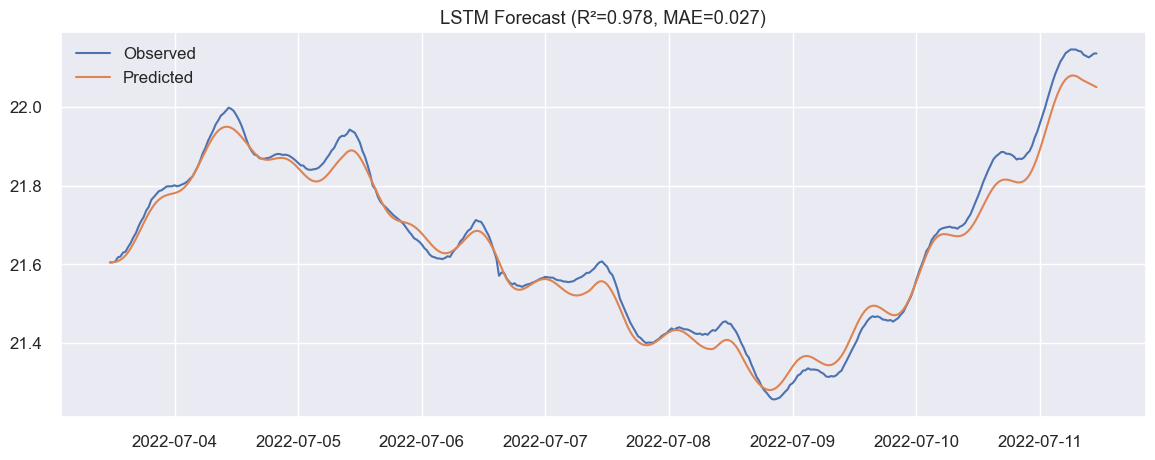

In [11]:
timestamps = df_model.index[window_size + val_end : window_size + val_end + len(y_test)]

plt.figure(figsize=(14,5))
plt.plot(timestamps, y_true, label="Observed")
plt.plot(timestamps, y_pred, label="Predicted")
plt.title(f"LSTM Forecast (R²={r2:.3f}, MAE={mae:.3f})")
plt.legend()
plt.grid(True)
plt.show()



 ## 8. Permutation Feature Importance

12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 119ms/step
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 98ms/step
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 122ms/step
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 107ms/step
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 104ms/step
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 110ms/step
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 115ms/step
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 107ms/step
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 108ms/step
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 93ms/step
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 88ms/step
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 86ms/step


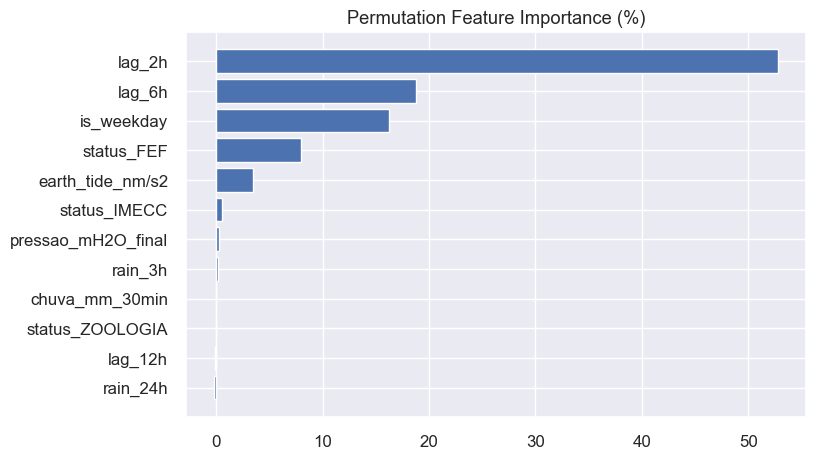

lag_2h: 52.79%
lag_6h: 18.76%
is_weekday: 16.24%
status_FEF: 7.98%
earth_tide_nm/s2: 3.46%
status_IMECC: 0.52%
pressao_mH2O_final: 0.30%
rain_3h: 0.19%
chuva_mm_30min: 0.02%
status_ZOOLOGIA: -0.05%
lag_12h: -0.06%
rain_24h: -0.15%


In [12]:
base_mse = mean_squared_error(y_test, y_pred_scaled)

feature_names = candidate_features
n_feat = len(feature_names)
importances = []

for j in range(n_feat):
    Xp = X_test.copy()
    perm = np.random.permutation(len(Xp))
    Xp[:, :, j] = Xp[perm, :, j]
    
    y_pp = final_model.predict(Xp)
    mse_p = mean_squared_error(y_test, y_pp)
    
    importances.append(mse_p - base_mse)

importances = np.array(importances)
importances_pct = importances / importances.sum() * 100

sorted_idx = np.argsort(importances)[::-1]

plt.figure(figsize=(8,5))
plt.barh(
    [feature_names[i] for i in sorted_idx][::-1],
    importances_pct[sorted_idx][::-1]
)
plt.title("Permutation Feature Importance (%)")
plt.show()

for i in sorted_idx:
    print(f"{feature_names[i]}: {importances_pct[i]:.2f}%")



 ## 9. SHAP Values

Computing SHAP values... this may take several minutes.


  0%|          | 0/80 [00:00<?, ?it/s]


=== SHAP Global Feature Importance ===
earth_tide_nm/s2: 0.000030
lag_2h: 0.000027
status_FEF: 0.000024
pressao_mH2O_final: 0.000018
status_IMECC: 0.000016
lag_6h: 0.000016
status_ZOOLOGIA: 0.000013
rain_24h: 0.000013
lag_12h: 0.000012
is_weekday: 0.000009
rain_3h: 0.000006
chuva_mm_30min: 0.000003


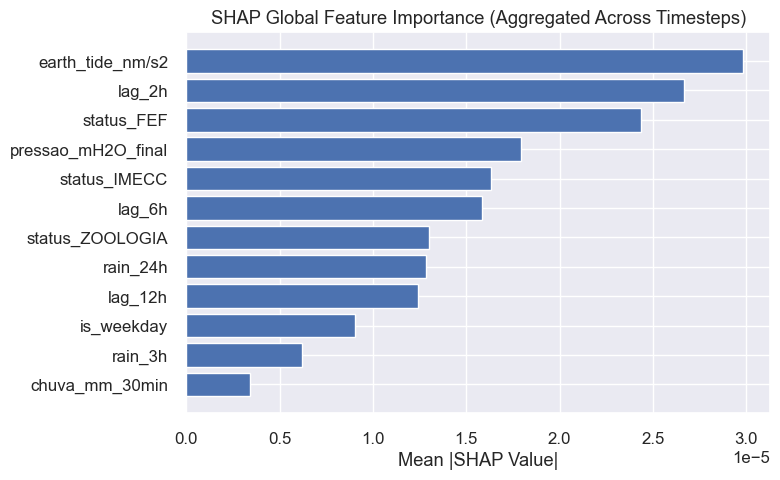

In [16]:
# ===============================================================
#  SHAP INTERPRETABILITY FOR LSTM WITH 3-D INPUTS
#  Works with sequences: (samples, time_steps, n_features)
# ===============================================================

import shap
import numpy as np
import matplotlib.pyplot as plt

# ------------------------------
# 1. Flatten sequences for SHAP
# ------------------------------

# Shape information
n_samples, time_steps, n_features = X_train.shape

# Flatten input sequences: (samples, time_steps * n_features)
X_train_flat = X_train.reshape((n_samples, time_steps * n_features))

# Select a small background sample (SHAP needs this)
X_background = X_train_flat[:50]


# ------------------------------------------------------
# 2. Wrapper: SHAP → reshape flat input → LSTM predict
# ------------------------------------------------------

def model_wrapper(x_flat):
    """
    Kernel SHAP passes 2-D arrays, so we reshape them back to
    (batch, time_steps, features) before calling the model.
    """
    x = x_flat.reshape((x_flat.shape[0], time_steps, n_features))
    preds = final_model.predict(x, verbose=0)
    return preds


# ------------------------------
# 3. Create KernelExplainer
# ------------------------------

explainer = shap.KernelExplainer(
    model=model_wrapper,
    data=X_background
)

# Choose a subset of samples to explain (Kernel SHAP is slow!)
X_sample = X_train_flat[:80]

print("Computing SHAP values... this may take several minutes.")
shap_values = explainer.shap_values(X_sample, nsamples=200)

# shap_values is shape: (samples, time_steps*n_features)


# ------------------------------------------------------------
# 4. Reshape SHAP results back to (samples, time, features)
# ------------------------------------------------------------

shap_values = np.array(shap_values)   # ensure numpy
shap_values = shap_values.reshape(
    len(X_sample),
    time_steps,
    n_features
)

# Absolute mean importance per feature aggregated across:
# - all samples
# - all time steps
mean_abs_shap = np.mean(np.abs(shap_values), axis=(0, 1))


# ------------------------------
# 5. Sort features by importance
# ------------------------------

sorted_idx = np.argsort(mean_abs_shap)[::-1]

print("\n=== SHAP Global Feature Importance ===")
for i in sorted_idx:
    print(f"{feature_names[i]}: {mean_abs_shap[i]:.6f}")


# ------------------------------
# 6. Plot global feature importance
# ------------------------------

plt.figure(figsize=(8, 5))
plt.barh(
    [feature_names[i] for i in sorted_idx][::-1],
    mean_abs_shap[sorted_idx][::-1]
)
plt.title("SHAP Global Feature Importance (Aggregated Across Timesteps)")
plt.xlabel("Mean |SHAP Value|")
plt.tight_layout()
plt.show()
